In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.fftpack

import pyrex

## Quick Links

[Working with Signal Objects](#signals)

[Antenna Class and Subclasses](#antennas)

[AntennaSystem and Detector Classes](#detector)

[Ice and Earth Models](#models)

[Particle Generation](#particles)

[Ray Tracing](#ray_tracing)

[Full Simulation](#kernel)

<a id="signals"></a>
# Working with Signal Objects

In [2]:
time_array = np.linspace(0, 10)
value_array = np.sin(time_array)
my_signal = pyrex.Signal(times=time_array, values=value_array)

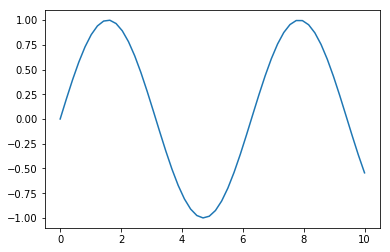

In [3]:
plt.plot(my_signal.times, my_signal.values)
plt.show()

In [4]:
my_voltage_signal = pyrex.Signal(times=time_array, values=value_array,
                                 value_type=pyrex.Signal.ValueTypes.voltage)

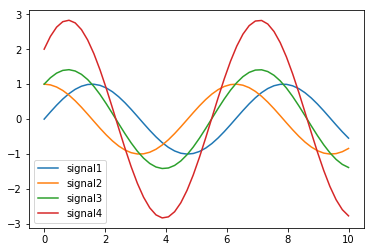

In [5]:
time_array = np.linspace(0, 10)
values1 = np.sin(time_array)
values2 = np.cos(time_array)
signal1 = pyrex.Signal(time_array, values1)
plt.plot(signal1.times, signal1.values, label="signal1")
signal2 = pyrex.Signal(time_array, values2)
plt.plot(signal2.times, signal2.values, label="signal2")
signal3 = signal1 + signal2
plt.plot(signal3.times, signal3.values, label="signal3")
all_signals = [signal1, signal2, signal3]
signal4 = sum(all_signals)
plt.plot(signal4.times, signal4.values, label="signal4")
plt.legend()
plt.show()

In [6]:
print(my_signal.dt == my_signal.times[1] - my_signal.times[0])
print(my_signal.spectrum == scipy.fftpack.fft(my_signal.values))
print(my_signal.frequencies == scipy.fftpack.fftfreq(n=len(my_signal.values), d=my_signal.dt))
print(my_signal.envelope == np.abs(scipy.signal.hilbert(my_signal.values)))

True
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


True
True
True


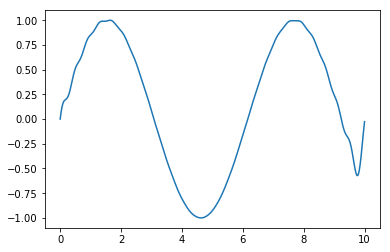

In [7]:
my_signal.resample(1001)
print(len(my_signal.times) == len(my_signal.values) == 1001)
print(my_signal.times[0] == 0)
print(my_signal.times[-1] == 10)
plt.plot(my_signal.times, my_signal.values)
plt.show()

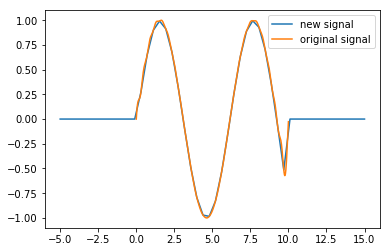

In [8]:
new_times = np.linspace(-5, 15)
new_signal = my_signal.with_times(new_times)
plt.plot(new_signal.times, new_signal.values, label="new signal")
plt.plot(my_signal.times, my_signal.values, label="original signal")
plt.legend()
plt.show()

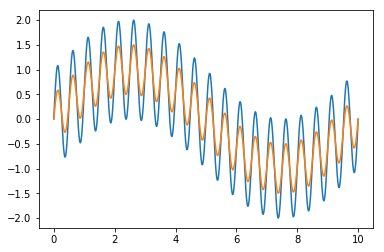

In [9]:
def lowpass_filter(frequency):
    if frequency < 1:
        return 1
    else:
        return 0
    
time_array = np.linspace(0, 10, 1001)
value_array = np.sin(0.1*2*np.pi*time_array) + np.sin(2*2*np.pi*time_array)
my_signal = pyrex.Signal(times=time_array, values=value_array)

plt.plot(my_signal.times, my_signal.values)
my_signal.filter_frequencies(lowpass_filter)
plt.plot(my_signal.times, my_signal.values)
plt.show()

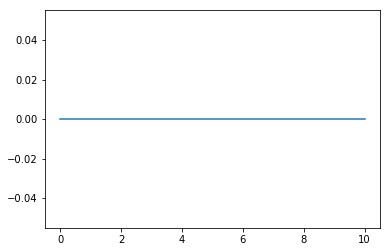

In [10]:
time_array = np.linspace(0,10)
empty = pyrex.EmptySignal(times=time_array)
plt.plot(empty.times, empty.values)
plt.show()

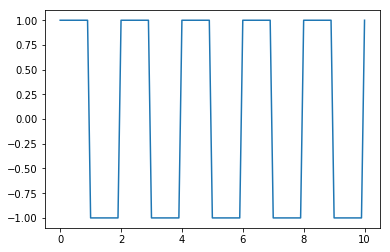

In [11]:
time_array = np.linspace(0, 10, num=101)
def square_wave(time):
    if int(time)%2==0:
        return 1
    else:
        return -1
square_signal = pyrex.FunctionSignal(times=time_array, function=square_wave)
plt.plot(square_signal.times, square_signal.values)
plt.show()

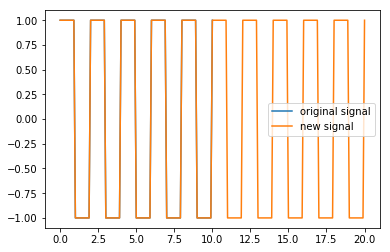

In [12]:
new_times = np.linspace(0, 20, num=201)
long_square_signal = square_signal.with_times(new_times)
plt.plot(square_signal.times, square_signal.values, label="original signal")
plt.plot(long_square_signal.times, long_square_signal.values, label="new signal")
plt.legend()
plt.show()

ValueTypes.field


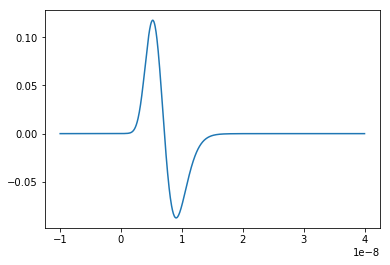

In [13]:
time_array = np.linspace(-10e-9, 40e-9, 1001)
neutrino_energy = 1e8 # GeV
observation_angle = 45 * np.pi/180 # radians
askaryan = pyrex.AskaryanSignal(times=time_array, energy=neutrino_energy,
                                theta=observation_angle)
print(askaryan.value_type)
plt.plot(askaryan.times, askaryan.values)
plt.show()

ValueTypes.voltage


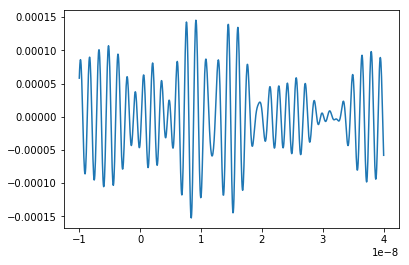

In [14]:
time_array = np.linspace(-10e-9, 40e-9, 1001)
noise_temp = 300 # K
system_resistance = 1000 # ohm
frequency_range = (550e6, 750e6) # Hz
noise = pyrex.ThermalNoise(times=time_array, temperature=noise_temp,
                           resistance=system_resistance,
                           f_band=frequency_range)
print(noise.value_type)
plt.plot(noise.times, noise.values)
plt.show()

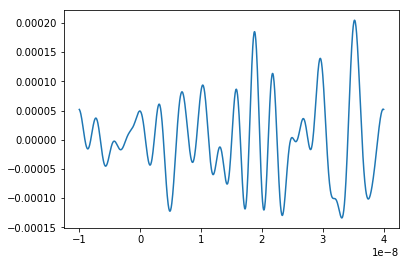

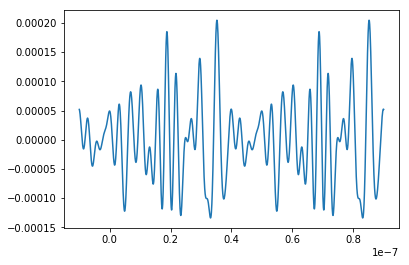

In [15]:
short_noise = pyrex.ThermalNoise(times=time_array, temperature=noise_temp,
                                 resistance=system_resistance,
                                 f_band=(100e6, 400e6))
long_noise = short_noise.with_times(np.linspace(-10e-9, 90e-9, 2001))

plt.plot(short_noise.times, short_noise.values)
plt.show()
plt.plot(long_noise.times, long_noise.values)
plt.show()

<a id="antennas"></a>
# Antenna Class and Subclasses

In [16]:
# Please note that some values are unrealistic in order to simplify demonstration
position = (0, 0, -100) # m
temperature = 300 # K
resistance = 1e17 # ohm
frequency_range = (0, 5) # Hz
basic_antenna = pyrex.Antenna(position=position, temperature=temperature,
                              resistance=resistance,
                              freq_range=frequency_range)
noiseless_antenna = pyrex.Antenna(position=position, noisy=False)

In [17]:
print(basic_antenna.is_hit == False)
print(basic_antenna.waveforms == [])

True
True


In [18]:
print(basic_antenna.efficiency == 1)
print(basic_antenna.antenna_factor == 1)
freqs = [1, 2, 3, 4, 5]
print(basic_antenna.response(freqs) == [1, 1, 1, 1, 1])
print(basic_antenna.directional_gain(theta=np.pi/2, phi=0) == 1)
print(basic_antenna.polarization_gain([0,0,1]) == 1)

True
True
[ True  True  True  True  True]
True
True


In [19]:
print(basic_antenna.trigger(pyrex.Signal([0],[0])) == True)

True


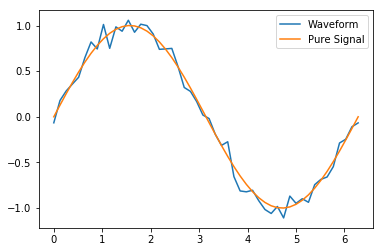

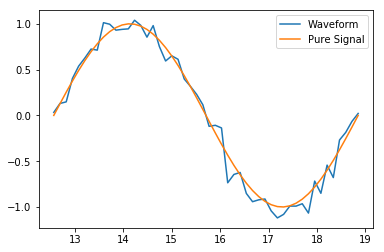

In [20]:
incoming_signal_1 = pyrex.FunctionSignal(np.linspace(0,2*np.pi), np.sin,
                                         value_type=pyrex.Signal.ValueTypes.voltage)
incoming_signal_2 = pyrex.FunctionSignal(np.linspace(4*np.pi,6*np.pi), np.sin,
                                         value_type=pyrex.Signal.ValueTypes.voltage)
basic_antenna.receive(incoming_signal_1)
basic_antenna.receive(incoming_signal_2, origin=[0,0,-300], polarization=[1,0,0])
basic_antenna.is_hit == True
for waveform, pure_signal in zip(basic_antenna.waveforms, basic_antenna.signals):
    plt.figure()
    plt.plot(waveform.times, waveform.values, label="Waveform")
    plt.plot(pure_signal.times, pure_signal.values, label="Pure Signal")
    plt.legend()
    plt.show()

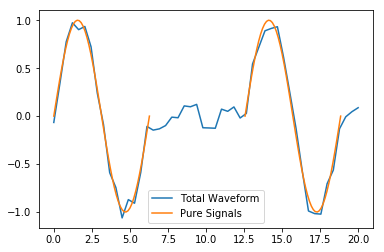

True


In [21]:
total_waveform = basic_antenna.full_waveform(np.linspace(0,20))
plt.plot(total_waveform.times, total_waveform.values, label="Total Waveform")
plt.plot(incoming_signal_1.times, incoming_signal_1.values, label="Pure Signals")
plt.plot(incoming_signal_2.times, incoming_signal_2.values, color="C1")
plt.legend()
plt.show()

print(basic_antenna.is_hit_during(np.linspace(0, 200e-9)) == True)

In [22]:
basic_antenna.clear()
print(basic_antenna.is_hit == False)
print(len(basic_antenna.waveforms) == 0)

True
True


In [23]:
class NoiselessThresholdAntenna(pyrex.Antenna):
    def __init__(self, position, threshold):
        super().__init__(position=position, noisy=False)
        self.threshold = threshold

    def trigger(self, signal):
        if max(np.abs(signal.values)) > self.threshold:
            return True
        else:
            return False

True
True
True
True
True
True


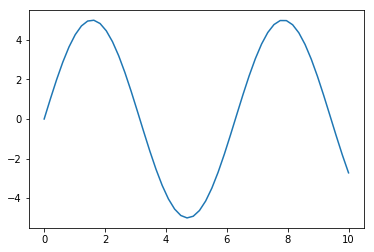

In [24]:
my_antenna = NoiselessThresholdAntenna(position=(0, 0, 0), threshold=2)

incoming_signal = pyrex.FunctionSignal(np.linspace(0,10), np.sin,
                                       value_type=pyrex.Signal.ValueTypes.voltage)
my_antenna.receive(incoming_signal)
print(my_antenna.is_hit == False)
print(len(my_antenna.waveforms) == 0)
print(len(my_antenna.all_waveforms) == 1)

incoming_signal = pyrex.Signal(incoming_signal.times,
                               5*incoming_signal.values,
                               value_type=incoming_signal.value_type)
my_antenna.receive(incoming_signal)
print(my_antenna.is_hit == True)
print(len(my_antenna.waveforms) == 1)
print(len(my_antenna.all_waveforms) == 2)

for wave in my_antenna.waveforms:
    plt.figure()
    plt.plot(wave.times, wave.values)
    plt.show()

In [25]:
antenna_identifier = "antenna 1"
position = (0, 0, -100)
center_frequency = 250e6 # Hz
bandwidth = 300e6 # Hz
resistance = 100 # ohm
antenna_length = 3e8/center_frequency/2 # m
polarization_direction = (0, 0, 1)
trigger_threshold = 1e-5 # V
dipole = pyrex.DipoleAntenna(name=antenna_identifier,position=position,
                             center_frequency=center_frequency,
                             bandwidth=bandwidth, resistance=resistance,
                             effective_height=antenna_length,
                             orientation=polarization_direction,
                             trigger_threshold=trigger_threshold)

<a id="detector"></a>
# AntennaSystem and Detector Classes

In [26]:
class PowerAntennaSystem(pyrex.AntennaSystem):
    """Antenna system whose signals and waveforms are powers instead of
    voltages."""
    def __init__(self, position, temperature, resistance, frequency_range):
        super().__init__(pyrex.Antenna)
        # The setup_antenna method simply passes all arguments on to the
        # antenna class passed to super.__init__() and stores the resulting
        # antenna to self.antenna
        self.setup_antenna(position=position, temperature=temperature,
                           resistance=resistance,
                           freq_range=frequency_range)

    def front_end(self, signal):
        return pyrex.Signal(signal.times, signal.values**2,
                            value_type=pyrex.Signal.ValueTypes.power)

True
True


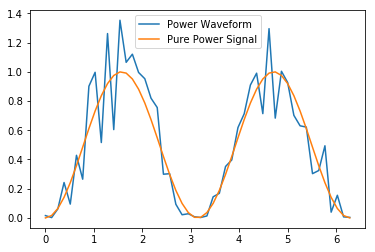

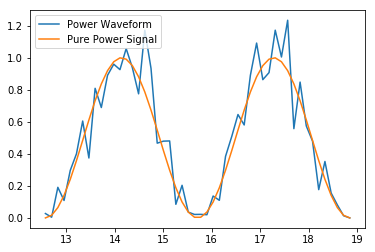

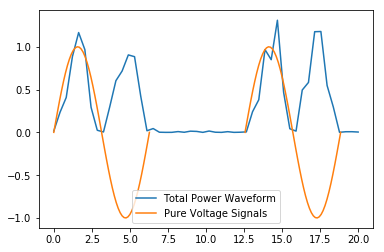

True
True
True


In [27]:
position = (0, 0, -100) # m
temperature = 300 # K
resistance = 1e17 # ohm
frequency_range = (0, 5) # Hz

basic_antenna_system = PowerAntennaSystem(position=position,
                                          temperature=temperature,
                                          resistance=resistance,
                                          frequency_range=frequency_range)

print(basic_antenna_system.trigger(pyrex.Signal([0],[0])) == True)

incoming_signal_1 = pyrex.FunctionSignal(np.linspace(0,2*np.pi), np.sin,
                                         value_type=pyrex.Signal.ValueTypes.voltage)
incoming_signal_2 = pyrex.FunctionSignal(np.linspace(4*np.pi,6*np.pi), np.sin,
                                         value_type=pyrex.Signal.ValueTypes.voltage)
basic_antenna_system.receive(incoming_signal_1)
basic_antenna_system.receive(incoming_signal_2, origin=[0,0,-300],
                             polarization=[1,0,0])
print(basic_antenna_system.is_hit == True)
for waveform, pure_signal in zip(basic_antenna_system.waveforms,
                                 basic_antenna_system.signals):
    plt.figure()
    plt.plot(waveform.times, waveform.values, label="Power Waveform")
    plt.plot(pure_signal.times, pure_signal.values, label="Pure Power Signal")
    plt.legend()
    plt.show()

total_waveform = basic_antenna_system.full_waveform(np.linspace(0,20))
plt.plot(total_waveform.times, total_waveform.values, label="Total Power Waveform")
plt.plot(incoming_signal_1.times, incoming_signal_1.values, label="Pure Voltage Signals")
plt.plot(incoming_signal_2.times, incoming_signal_2.values, color="C1")
plt.legend()
plt.show()

print(basic_antenna_system.is_hit_during(np.linspace(0, 200e-9)) == True)

basic_antenna_system.clear()
print(basic_antenna_system.is_hit == False)
print(len(basic_antenna_system.waveforms) == 0)

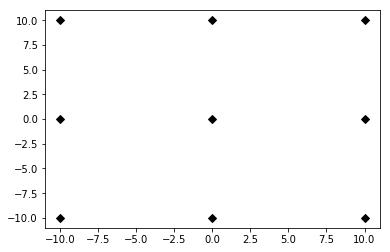

In [28]:
class AntennaGrid(pyrex.Detector):
    """A detector composed of a plane of antennas in a rectangular grid layout
    some distance below the ice."""
    def set_positions(self, number, separation=10, depth=-50):
        self.antenna_positions = []
        n_x = int(np.sqrt(number))
        n_y = int(number/n_x)
        dx = separation
        dy = separation
        for i in range(n_x):
            x = -dx*n_x/2 + dx/2 + dx*i
            for j in range(n_y):
                y = -dy*n_y/2 + dy/2 + dy*j
                self.antenna_positions.append((x, y, depth))

grid_detector = AntennaGrid(9)

# Build the antennas
temperature = 300 # K
resistance = 1e17 # ohm
frequency_range = (0, 5) # Hz
grid_detector.build_antennas(pyrex.Antenna, temperature=temperature,
                             resistance=resistance,
                             freq_range=frequency_range)

for antenna in grid_detector:
    x = antenna.position[0]
    y = antenna.position[1]
    plt.plot(x, y, "kD")
plt.show()

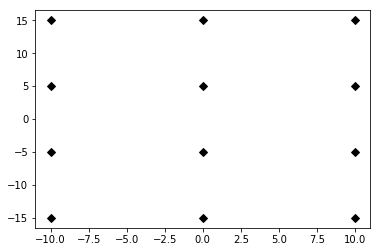

In [29]:
grid_detector = AntennaGrid(12)

# Build the antennas
temperature = 300 # K
resistance = 1e17 # ohm
frequency_range = (0, 5) # Hz
grid_detector.build_antennas(PowerAntennaSystem, temperature=temperature,
                             resistance=resistance,
                             frequency_range=frequency_range)

for antenna in grid_detector:
    x = antenna.antenna.position[0]
    y = antenna.antenna.position[1]
    plt.plot(x, y, "kD")
plt.show()

<a id="models"></a>
# Ice and Earth Models

In [30]:
depth = -1000 # m
print(pyrex.IceModel.temperature(depth))
print(pyrex.IceModel.index(depth))
print(pyrex.IceModel.gradient(depth))
frequency = 1e8 # Hz
print(pyrex.IceModel.attenuation_length(depth, frequency))

226.57523999999998
1.77999920424
[  0.00000000e+00   0.00000000e+00  -1.05040124e-08]
1901.61734555


In [31]:
radius = 6360000 # m
pyrex.prem_density(radius)

2.6

In [32]:
nadir_angle = 60 * np.pi/180 # radians
depth = 1000 # m
pyrex.slant_depth(nadir_angle, depth)

2551914588.6298146

<a id="particles"></a>
# Particle Generation

In [33]:
initial_position = (0,0,0) # m
direction_vector = (0,0,-1)
particle_energy = 1e8 # GeV
pyrex.Particle(vertex=initial_position, direction=direction_vector,
               energy=particle_energy)

In [34]:
box_width = 1000 # m
box_depth = 500 # m
const_energy_generator = lambda: 1e8 # GeV
my_generator = pyrex.ShadowGenerator(dx=box_width, dy=box_width,
                                     dz=box_depth,
                                     energy_generator=const_energy_generator)
my_generator.create_particle()

<a id="ray_tracing"></a>
# Ray Tracing

In [35]:
start = (0, 0, -250) # m
finish = (750, 0, -100) # m
my_ray_tracer = pyrex.RayTracer(from_point=start, to_point=finish)

In [36]:
print(my_ray_tracer.exists)
print(my_ray_tracer.solutions)

True
[<pyrex.ray_tracing.SpecializedRayTracePath object at 0x111b776d8>, <pyrex.ray_tracing.SpecializedRayTracePath object at 0x111b77470>]


In [37]:
my_path = my_ray_tracer.solutions[0]
print(my_path.tof)
print(my_path.path_length)
print(my_path.emitted_direction)
print(my_path.received_direction)

4.38909768635e-06
771.356000025
[ 0.94039118  0.          0.34009474]
[ 0.99630666  0.         -0.08586643]


[ 0.76730746]
[ 0.76730746  0.68491608  0.63793496  0.60408896  0.57738512  0.55523965]


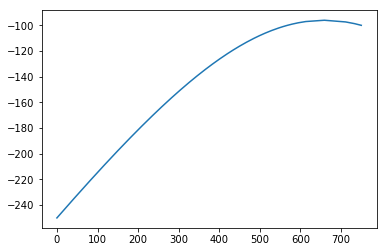

In [38]:
frequency = 500e6 # Hz
print(my_path.attenuation(100e6))
print(my_path.attenuation(np.linspace(1e8, 1e9, 6)))
plt.plot(my_path.coordinates[0], my_path.coordinates[2])
plt.show()

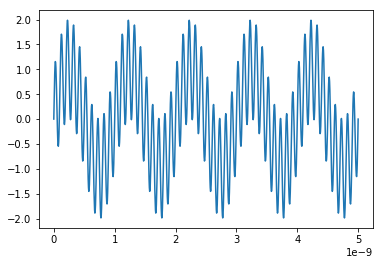

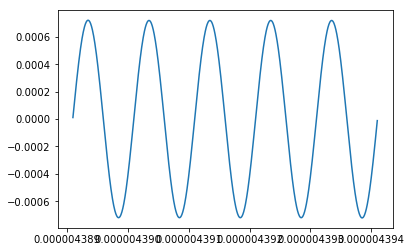

In [39]:
time_array = np.linspace(0, 5e-9, 1001)
my_signal = (pyrex.FunctionSignal(time_array, lambda t: np.sin(1e9*2*np.pi*t))
            + pyrex.FunctionSignal(time_array, lambda t: np.sin(1e10*2*np.pi*t)))
plt.plot(my_signal.times, my_signal.values)
plt.show()

my_path.propagate(my_signal)
my_signal.values /= my_path.path_length
plt.plot(my_signal.times, my_signal.values)
plt.show()

<a id="kernel"></a>
# Full Simulation

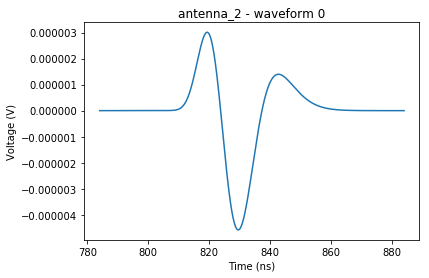

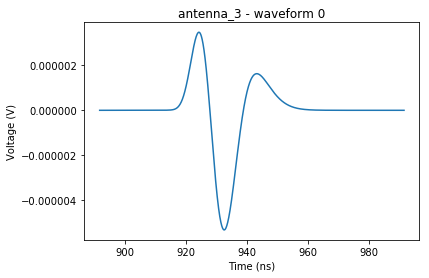

In [40]:
particle_generator = pyrex.ShadowGenerator(dx=1000, dy=1000, dz=500,
                                           energy_generator=lambda: 1e8)
detector = []
for i, z in enumerate([-100, -150, -200, -250]):
    detector.append(
        pyrex.DipoleAntenna(name="antenna_"+str(i), position=(0, 0, z),
                            center_frequency=250e6, bandwidth=300e6,
                            resistance=0, effective_height=0.6,
                            trigger_threshold=0, noisy=False)
    )
kernel = pyrex.EventKernel(generator=particle_generator,
                           ice_model=pyrex.IceModel,
                           antennas=detector)

triggered = False
while not triggered:
    kernel.event()
    for antenna in detector:
        if antenna.is_hit:
            triggered = True
            break

for antenna in detector:
    for i, wave in enumerate(antenna.waveforms):
        plt.plot(wave.times * 1e9, wave.values)
        plt.xlabel("Time (ns)")
        plt.ylabel("Voltage (V)")
        plt.title(antenna.name + " - waveform "+str(i))
        plt.show()